In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, LSTM
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv("out/Data.csv")
X = data.iloc[:, :-1]
y = data['AttackOrNot']


smote = SMOTE(sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X, y)


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=100)


X_train.shape[1]
print(X_resampled.shape)
print(y_resampled.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8464, 45)
(8464,)
(5924, 45)
(5924,)
(2540, 45)
(2540,)


In [3]:
# Apply PCA for feature engineering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pca = PCA(n_components=20)  # Retain 95% of variance
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)


# # Calculate Pearson correlation coefficients between features and target variable
# correlations = np.corrcoef(X_resampled, y_resampled, rowvar=False)[:-1, -1]
# # Set a correlation threshold (you can adjust this value)
# correlation_threshold = 0.1

# # Select features with absolute correlation above the threshold
# selected_features = X.columns[abs(correlations) > correlation_threshold]
# # Subset the dataset with the selected features
# X_selected = X_resampled[selected_features]
# # Split the data into training and testing sets
# X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.2, random_state=42)

# # Standardize the selected data
# scaler_selected = StandardScaler()
# X_train = scaler_selected.fit_transform(X_train_selected)
# X_test = scaler_selected.transform(X_test_selected)

# 


# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# # Standardize the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Apply Linear Discriminant Analysis for dimensionality reduction
# lda = LinearDiscriminantAnalysis(n_components=min(X.shape[1], len(set(y)) - 1))
# X_train = lda.fit_transform(X_train_scaled, y_train)
# X_test = lda.transform(X_test_scaled)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(5924, 20)
(2540, 20)
(5924,)
(2540,)


In [5]:
input_shape = (X_train.shape[1],)

model = tf.keras.Sequential()


# Add the input layer
model.add(Dense(64, input_shape=input_shape, activation='relu'))
# Add additional dense layers
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))


# Output layer with a sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))


model.summary()
start_time = time.time()
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
training_time = training_time * 1e6

# Print the training time
print(f"Elapsed time: {training_time:.2f} microseconds")
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Make predictions on the test set
predictions = model.predict(X_test)

# # Print the accuracy of the model
print('Test accuracy:', test_accuracy)


y_pred = (model.predict(X_test) > 0.5).astype("int32")
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(conf_matrix)
print('\nClassification Report:')
print(classification_rep)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                1344      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3969 (15.50 KB)
Trainable params: 3969 (15.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Elapsed time: 7184.03 microseconds
Epoch 1/10
60/60 [==============================] - 1s 4ms/step - loss: 0.4538 - accuracy: 0.8413 - val_loss: 0.2517 

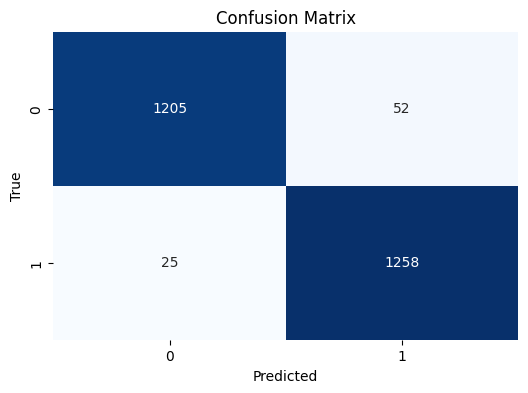

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc,recall_score, roc_auc_score, precision_recall_curve, average_precision_score, precision_score, accuracy_score, f1_score
# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

80/80 [==============================] - 0s 1ms/step
Precision: 94.86%
Accuracy: 96.89%
F1 Score: 96.99%
Recall: 99.22%


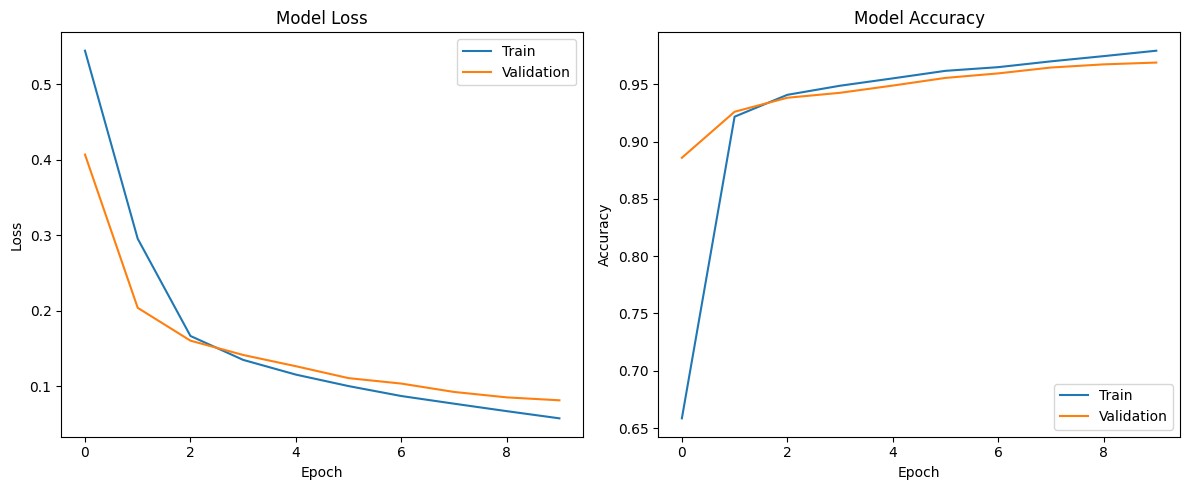

In [20]:
y_pred_proba = model.predict(X_test)


# Calculate evaluation metrics
precision = precision_score(y_test, y_pred) * 100
accuracy = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100

# Print the metrics
print("Precision: {:.2f}%".format(precision))
print("Accuracy: {:.2f}%".format(accuracy))
print("F1 Score: {:.2f}%".format(f1))
print("Recall: {:.2f}%".format(recall))




# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

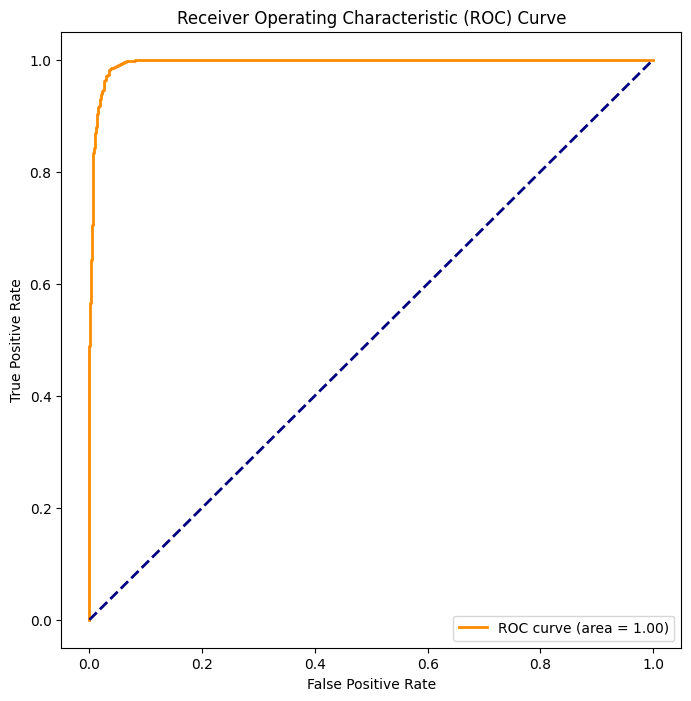

In [21]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


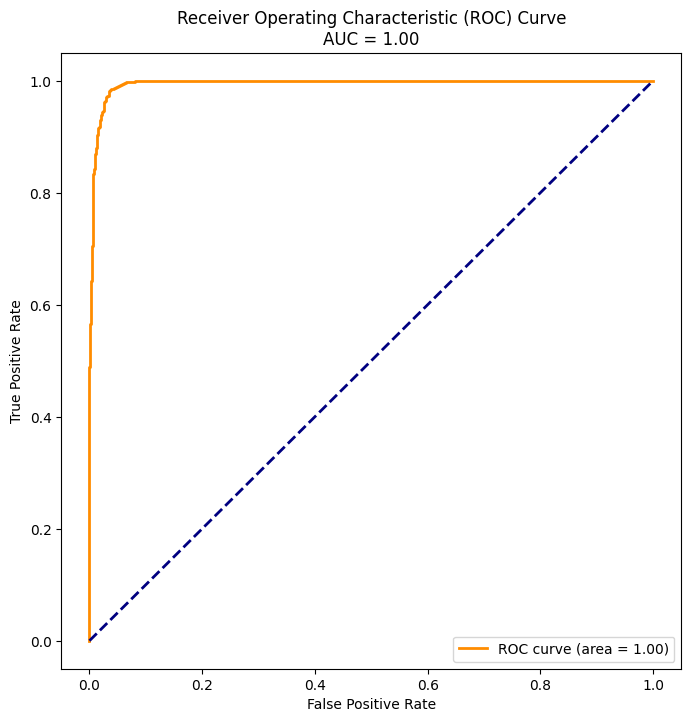

In [22]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with AUC value
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAUC = {:.2f}'.format(roc_auc))
plt.legend(loc='lower right')
plt.show()
